In [1]:
# If running locally
!pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 KB 3.8 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append(".")

from src.data.cmems_dataset import load_cmems_uv, SlidingWindowUVDataset
from src.models.unet_convlstm import UNetConvLSTM


In [3]:
data_path = "/home/svillhauer/Desktop/Thesis/Currents/deep_spatiotemporal_currents/src/data/cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1770985217793.nc"

uv, time, lat, lon = load_cmems_uv(
    data_path,
    u_var="utotal",
    v_var="vtotal",
    depth_index=0,
    regrid_hw=(64,64)   # optional but recommended
)

print(uv.shape)  # (T,2,H,W)


(1045, 2, 64, 64)


In [4]:
from src.data.cmems_dataset import compute_minmax, apply_minmax

seq_len = 3

split_t = int(len(uv)*0.7)
uv_train = uv[:split_t]
uv_val = uv[split_t:]

stats = compute_minmax(uv_train)
uv_train_n = apply_minmax(uv_train, stats)
uv_val_n = apply_minmax(uv_val, stats)

train_ds = SlidingWindowUVDataset(uv_train_n, seq_len=seq_len)
val_ds   = SlidingWindowUVDataset(uv_val_n,   seq_len=seq_len)


In [5]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4)

model = UNetConvLSTM(in_ch=2, out_ch=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

def rmse(a,b): 
    return torch.sqrt(torch.mean((a-b)**2))

epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for X,Y in train_loader:
        X,Y = X.to(device), Y.to(device)
        
        pred = model(X)
        loss = torch.mean((pred-Y)**2)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        train_loss += loss.item()
    
    model.eval()
    val_rmse = 0
    with torch.no_grad():
        for X,Y in val_loader:
            X,Y = X.to(device), Y.to(device)
            pred = model(X)
            val_rmse += rmse(pred,Y).item()
    
    print(f"Epoch {epoch}: train={train_loss:.4f}  val_rmse={val_rmse:.4f}")


Epoch 0: train=1.1468  val_rmse=2.0793
Epoch 1: train=0.1043  val_rmse=1.7810
Epoch 2: train=0.0730  val_rmse=1.6156
Epoch 3: train=0.0726  val_rmse=1.4770
Epoch 4: train=0.0664  val_rmse=1.6218
Epoch 5: train=0.0627  val_rmse=1.5057
Epoch 6: train=0.0544  val_rmse=1.4481
Epoch 7: train=0.0565  val_rmse=1.4048
Epoch 8: train=0.0534  val_rmse=1.9979
Epoch 9: train=0.0572  val_rmse=1.5434


In [6]:
t = 100
X = uv_val_n[t-seq_len:t]

with torch.no_grad():
    pred = model(torch.tensor(X[None]).to(device)).cpu().numpy()[0]

pred.shape   # (2,H,W)


(2, 64, 64)

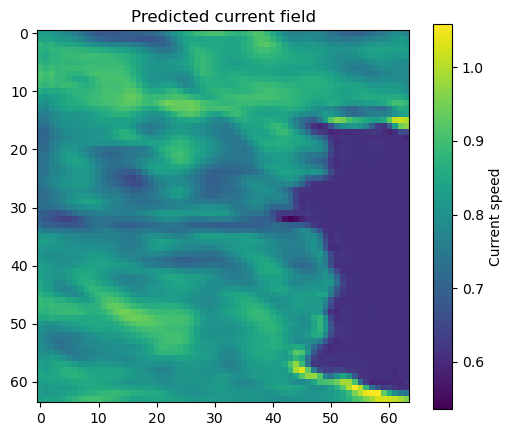

In [7]:
import matplotlib.pyplot as plt
import numpy as np

u_pred, v_pred = pred
speed = np.sqrt(u_pred**2 + v_pred**2)

plt.figure(figsize=(6,5))
plt.imshow(speed)
plt.colorbar(label="Current speed")
plt.title("Predicted current field")
plt.show()
